In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/massil/repos/newsvendor_tester


In [2]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

from environment import *
from algorithms.ddm import DDM_algorithm
from algorithms.rcosd_adaptive_volume_constrained import RCOSD_Adaptive_Volume_Constrained_algorithm
from algorithms.cosd_adaptive_volume_constrained import COSD_Adaptive_Volume_Constrained_algorithm
from simulator import Simulator

from tqdm import tqdm

### Defining the demand process
Here we define a perishable environment such that $n=1$, $T=2000$ and $d_t= \text{round}(Z^+)$ where $Z\sim\mathcal{N}(1,1)$ and $\text{round}$ , with losses $\ell_t(y) = |y-d_t|$.

Notice that in this example $\rho=1$

In [3]:
nb_products = 3
horizon = 500

def env_generator() :
    demands = np.zeros((horizon+1,nb_products))
    demands[1:,0] = scipy.stats.poisson(25).rvs(size=(horizon))
    demands[1:,1] = scipy.stats.poisson(15).rvs(size=(horizon))
    demands[1:,2] = scipy.stats.poisson(10).rvs(size=(horizon))
    #demands[1:,3] = scipy.stats.poisson(1).rvs(size=(horizon))
    return Environment_NonPerishable_L1(demands)

In [4]:
np.quantile(env_generator().demands[1:,:],0.5,axis=0)

array([25., 15., 10.])

Plotting a demand realizations and histogram

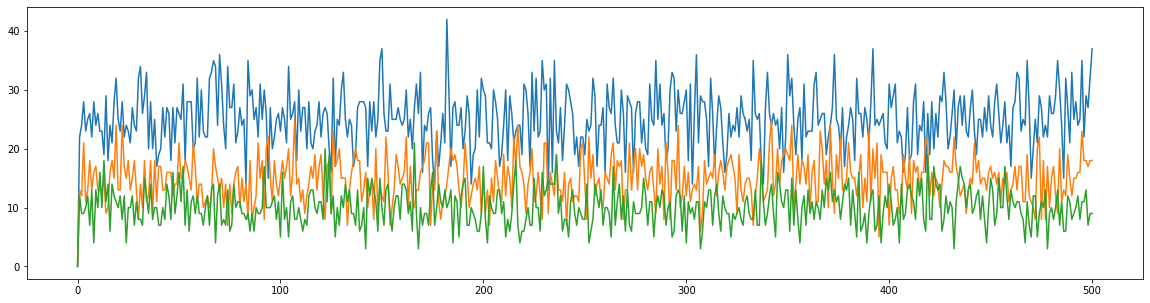

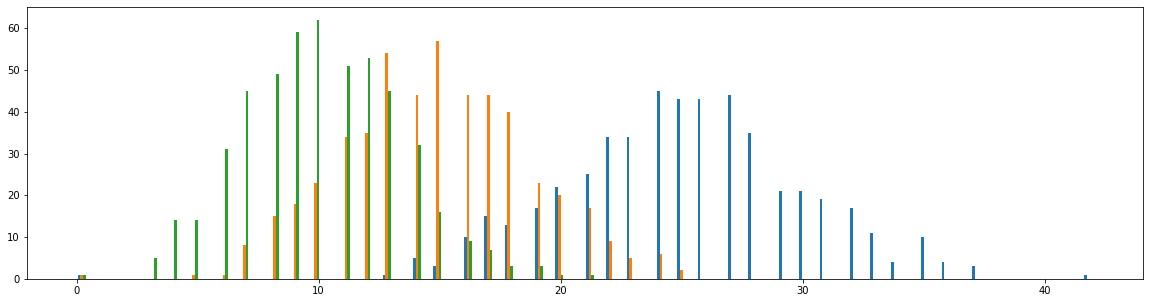

In [5]:
demands_example = env_generator().demands
plt.figure(figsize=(20,5))
plt.plot(demands_example)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(demands_example,bins=100)
plt.show()

### Defining the algorithms

The box constraint, the hyperparameter $\gamma\leq \rho/D$ and the gradients' norm upper bound $G$

In [6]:
volumes = np.ones(nb_products)
total_volume = 55
diameter = np.minimum(total_volume*np.sqrt(2)/np.min(volumes), total_volume*np.sqrt(np.sum(1/volumes**2)))
gamma = 1/diameter
G = np.sqrt(nb_products)*1.

The algorithms

In [7]:
nb_algs = 3
initial_decision = np.array([53,1,1])
algs = [
    COSD_Adaptive_Volume_Constrained_algorithm(initial_decision,volumes,total_volume,gamma),
    RCOSD_Adaptive_Volume_Constrained_algorithm(initial_decision,volumes,total_volume,gamma),
    DDM_algorithm(initial_decision,volumes,total_volume,gamma,G)
]

Building the simulator which wraps the main loop

In [8]:
nb_samples = 10
horizons = np.linspace(10,horizon,100).astype(int)

sim = Simulator(env_generator, nb_products, nb_samples, horizons, algs,
    lambda optimum : np.sum(volumes*optimum)<=total_volume)
cum_losses = sim.run()

  0%|          | 0/10 [00:00<?, ?it/s]


AssertionError: Bounds do not respect the constraint: np.sum(volumes*min_bounds) <= total_volume

In [ ]:
for i in range(nb_algs) :
    print("Alg {} ({}) final regret: {}, final regret std: {}".format(
        i,
        algs[i],
        np.mean((cum_losses[:,i+1,-1]-cum_losses[:,0,-1])),
        np.std(cum_losses[:,i+1,-1]-cum_losses[:,0,-1])
        #np.std(np.sum(losses[:,i+1,:],axis=1)-np.sum(losses[:,0,:],axis=1))
    ))

Alg 0 (COSD $\gamma=0.0128564869306645$) final regret: 4148.796465500084, final regret std: 108.69297687546916
Alg 1 (RCOSD $\gamma=0.0128564869306645$) final regret: 4755.776762396757, final regret std: 92.39346521308845


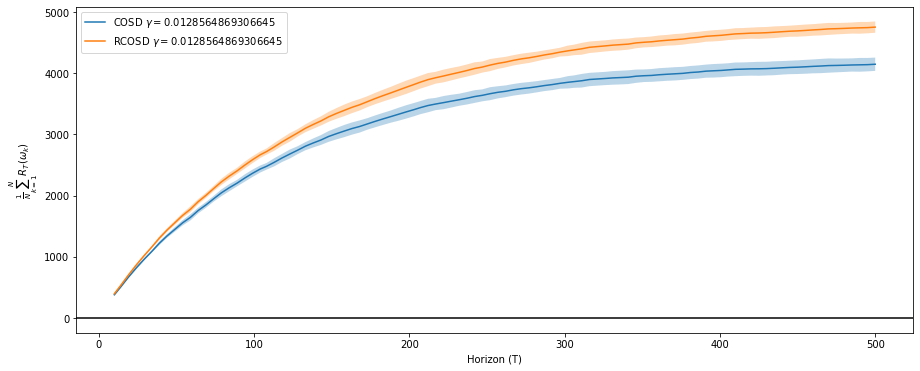

In [ ]:
plt.figure(figsize=(15,6))
for i in range(nb_algs) :
    y = np.mean(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    std = np.std(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    plt.plot(horizons, y,label=algs[i])
    plt.fill_between(horizons, y-std,y+std,alpha=0.3)
plt.axhline(0,color="k")
#plt.plot(horizons,np.sqrt(horizons)*D/2*np.sqrt(2/np.pi),"--",color="k",label="theoretical equivalent")
#plt.plot(horizons,np.sqrt(horizons)*D/(4*np.sqrt(2)),"x",color="k",label="theoretical lower bound")
plt.ylabel(r"$\frac{1}{N}\sum_{k=1}^N R_T(\omega_k)$")
plt.xlabel("Horizon (T)")
plt.legend()
plt.show()

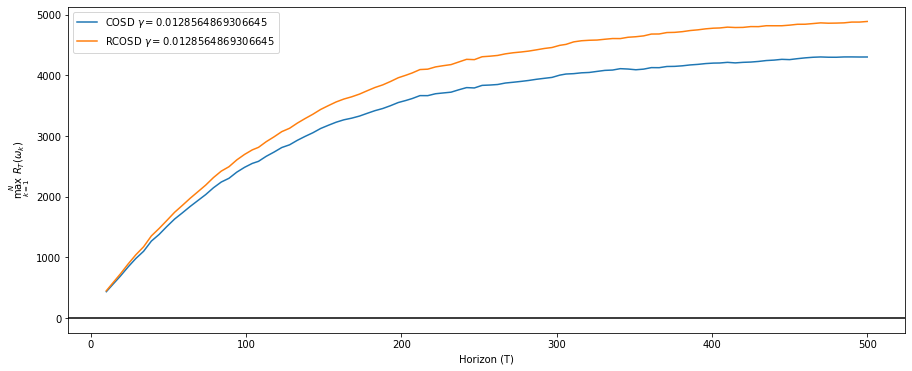

In [ ]:
plt.figure(figsize=(15,6))
for i in range(nb_algs) :
    plt.plot(horizons, np.max(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0),label=algs[i])
plt.axhline(0,color="k")
#plt.plot(horizons,(1/(2*gamma_1/20)+gamma_1/20)*D*G*np.sqrt(horizons),"--",color="blue",label="regret upper bound for gamma={}".format(gamma_1/20))
#plt.plot(horizons,(1/(2*gamma_1/5)+gamma_1/5)*D*G*np.sqrt(horizons),"--",color="orange",label="regret upper bound for gamma={}".format(gamma_1/5))
#plt.plot(horizons,(1/(2*gamma_1)+gamma_1)*D*G*np.sqrt(horizons),"--",color="green",label="regret upper bound for gamma={}".format(gamma_1))
plt.ylabel(r"$\max_{k=1}^N \ R_T(\omega_k)$")
plt.xlabel("Horizon (T)")
plt.legend()
plt.show()